In [35]:
# %load ../start.py
# Load useful extensions

# Activate the autoreload extension for easy reloading of external packages
%reload_ext autoreload
%autoreload 1

# Set up cashdir
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# Trun on the water mark
%reload_ext watermark
%watermark -u -d -v

# Load ipycache extension
%reload_ext ipycache
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# Add project library to path
import sys
sys.path.insert(0, '../../lib/python')


last updated: 2016-10-12 

CPython 3.5.2
IPython 5.1.0


In [36]:
# imports
import os
from glob import glob
import gzip

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import seaborn as sns
sns.set_context('poster')

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score

# Input Data

Using expression index values from Magic. There are a total of 17,501 genes and 14,705 samples. I removed 480 genes that were not expressed in any sample, and 102 samples that had no expression. The feature space (genes) was reduced from 17,501 features to 1500 features using PCA. The remaining features explain ~85% of the variance.

In [37]:
def translate(x):
    t = []
    for v in x:
        if v.startswith('000'):
            t.append(0)
        else:
            t.append(float(v.lstrip('0')))
    return t

In [4]:
%%cache -s jean_expression.pkl jean
dfs = []
for file in glob('../../data/jean/Expression/dd*GENE*.gz'):
    with gzip.open(file, 'rt') as fh:
        cnt = 0
        rows = []
        fbgns = []
        for row in fh:
            row = row.strip()
            if cnt == 26:
                cols = row.split('\t')
                download = cols[11]
                header = cols[13:]
            elif cnt > 30:
                cols = row.split('\t')
                fbgn = cols[0]
                values = cols[13:]
                rows.append(translate(values))
                fbgns.append(fbgn)
            cnt+=1

    dfs.append(pd.DataFrame(rows, columns=header, index=fbgns))

jean = pd.concat(dfs, axis=1)

In [5]:
# Data are log so there are -inf number due to log(0) replace those with 0
jean.replace(np.inf, 0, inplace=True)
jean.replace(-np.inf, 0, inplace=True)
jean.fillna(0, inplace=True)

In [6]:
# drop rows and columsn that have all 0's
c_zero = (jean == 0).all(axis=0)
r_zero = (jean == 0).all(axis=1)
cleaned = jean.loc[~r_zero, ~c_zero]
cleaned_cols = cleaned.columns.tolist()
cleaned_rows = cleaned.index.tolist()
jr, jc = jean.shape
cr, cc = cleaned.shape
del jean

In [7]:
%%cache -s jean_expression_pca_projection.pkl projection
# Standardize (x-u)/std
scaler = StandardScaler()
scaled = scaler.fit_transform(cleaned.values.T)
del cleaned

# Build PCA
pca = IncrementalPCA(whiten=True)

# Calcualte projection
projection = pca.fit_transform(scaled)

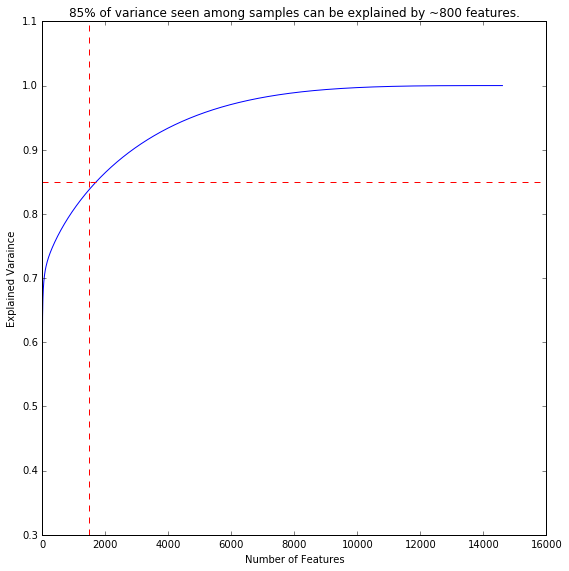

In [12]:
# Plot variance explained
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.axvline(1500, color='r', ls='--')
ax.axhline(.85, color='r', ls='--')
ax.set_title("85% of variance seen among samples can be explained by ~800 features.")
ax.set_ylabel('Explained Varaince')
ax.set_xlabel('Number of Features')
plt.tight_layout()

In [13]:
jean_projected = projection[:, :1500]

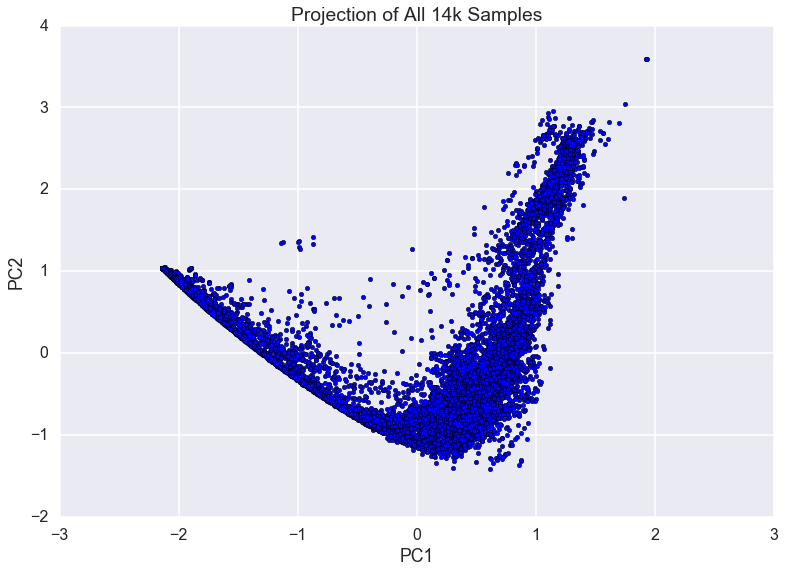

In [31]:
fig, ax = plt.subplots(1, 1)
ax.scatter(jean_projected[:,0], jean_projected[:, 1])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Projection of All 14k Samples')

http://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient

In [39]:
def sillhouette(X, Method=AgglomerativeClustering, clusters=[1000, 14000]):
    range_n_clusters = clusters
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1
        ax1.set_xlim([-1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = Method(n_clusters=n_clusters)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-1, -0.5, -0.25, 0, 0.25, 0.5, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors)

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1],
                    marker='o', c="white", alpha=1, s=200)

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()

# Kmeans

For n_clusters = 100 The average silhouette_score is : -0.122032419365


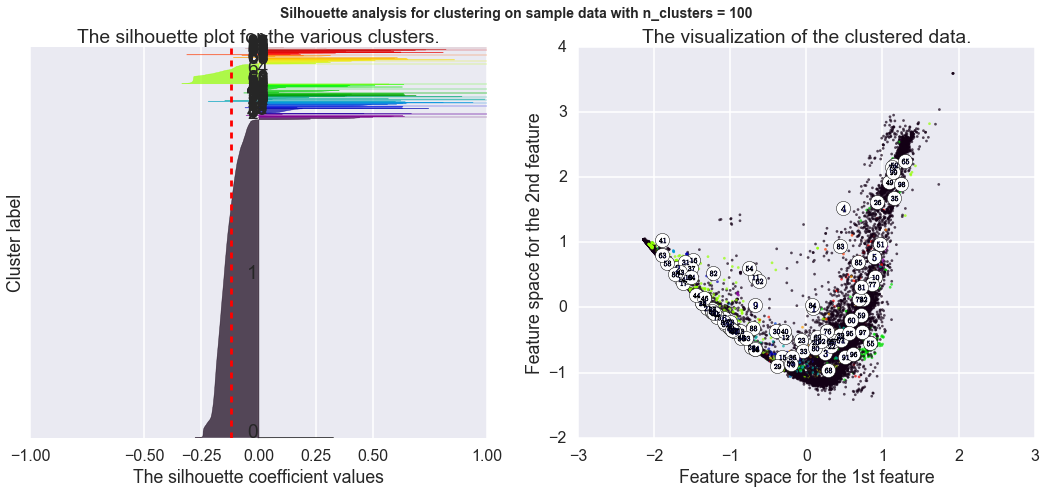

In [34]:
sillhouette(jean_projected, KMeans, [100])

http://scikit-learn.org/stable/modules/clustering.html#calinski-harabaz-index

# Agglomerative Clustering

In [ ]:
sillhouette(jean_projected, AgglomerativeClustering)

For n_clusters = 1000 The average silhouette_score is : 0.0328404251822


# DBSCAN

In [ ]:
db = DBSCAN(eps=0.3, min_samples=10).fit(X)